### Gaussian mixture 

## $\pi (x) = \frac{1}{2(2\pi)^{d/2}} \left( e ^{\frac{-| x-a|^2}{2}}  + e ^{\frac{-| x+a|^2}{2}} \right), \quad x \in\mathbb R^d$

$U(x) = \frac{1}{2} \|x - a\|_2^2 - \text{log}(1 + e^{-2x^\top a})$

$\nabla U(x) = x-a +2a(1 + e^{2 x^\top a})^{-1}$

$ m = 1 - \|a \|_2^2 \quad $ (strongly convex function)

$M = 1 \quad$  (Lipschitz continuous gradient)

$a = (\frac{1}{\sqrt{2d}}, \dots, \frac{1}{\sqrt{2d}})$

##### Setup:

d = 2

n = 1000

N = 50000

N_train = 500 (100)

N_test = 200

polynomials_max_deg = 5

$f(x) = x_1 + x_2$

$K = 2$

In [1]:
import numpy as np
import scipy 
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from scipy.misc import comb
from matplotlib import pyplot as plt
from scipy.special import hermitenorm
from tqdm import tqdm
from numpy.polynomial.hermite_e import HermiteE
import matplotlib.mlab as mlab
%matplotlib inline
from joblib import Parallel, delayed
from scipy.optimize import minimize
from itertools import product
import sys
import warnings
from sklearn import linear_model
import math
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from numpy.random import normal  
import timeit

### Parameters inicialization, ULA algorithm

In [2]:
d = 2
a = np.ones((d,1)) / np.sqrt(2*d)

def f_grad(x):
    return x-a+2*a/(1 + np.exp(2* (x.T @ a)))

def generate_lmc(a,d,N):
    h = 0.1
    K = 10000
    vkh = np.empty((K + N,d,1))
    ksi = np.random.randn(K+N,d,1)
    vkh[0] = (np.random.normal(0,1,d)).reshape(d,1)
    for i in range(1,K+N):
        grad = f_grad(vkh[i-1])
        vkh[i] = vkh[i-1] - h*grad + np.sqrt(2*h) * ksi[i]
    return vkh[K:], ksi[K:]

### Sample generation

In [3]:
np.random.seed(2342)
X, Z = generate_lmc(a,d, 1000000)

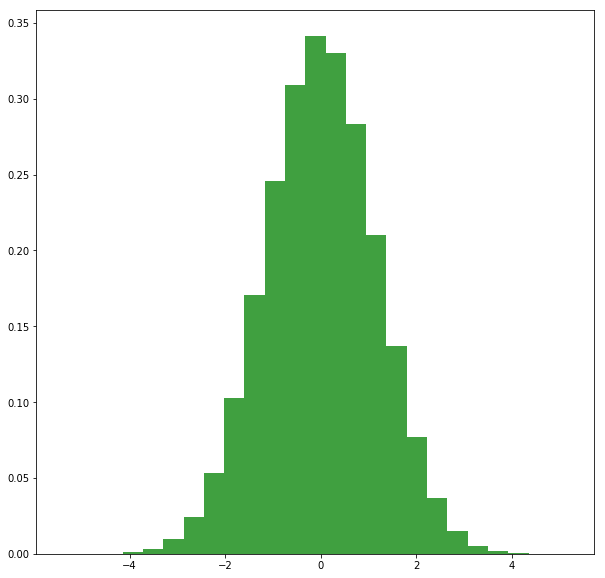

In [4]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(X[:,1].reshape(-1,1), 25, density=True, facecolor='g', alpha=0.75)
x = np.linspace(-5,5,100)
plt.show()

### Ordinary weighted estimator with $$f(x) = x$$

In [5]:
def local_weighted_estimator(X):
    return X[:,0].mean() + X[:,1].mean()

In [6]:
print ("Weighted estimator = ",local_weighted_estimator(X))

Weighted estimator =  -0.00790899409333


### Generation of N_train independent paths

In [7]:
def generate_lmc_from_initial(x_initial,a,d,N):
    h = 0.1
    vkh = np.empty((N,d,1))
    ksi = np.random.randn(N,d,1)
    vkh[0] = x_initial
    for i in range(1,N):
        grad = f_grad(vkh[i-1])
        vkh[i] = vkh[i-1] - h*grad + np.sqrt(2*h) * ksi[i]
    return vkh, ksi

def generate_paths(x_initial,N_train,a,d,N):
    XX = []
    ZZ = []
    for i in range(N_train):
        X, Z = generate_lmc_from_initial(x_initial[-i],a,d,N)
        XX.append(X)
        ZZ.append(Z)
    return np.array(XX),np.array(ZZ)

In [12]:
np.random.seed(123)
XX, ZZ = generate_paths(X,1000,a,d,1000)

In [13]:
XX.shape

(1000, 1000, 2, 1)

### Generate validation path

In [14]:
np.random.seed(42)
X_validate, Z_validate = generate_lmc_from_initial(X[-5000],a,d,1000)

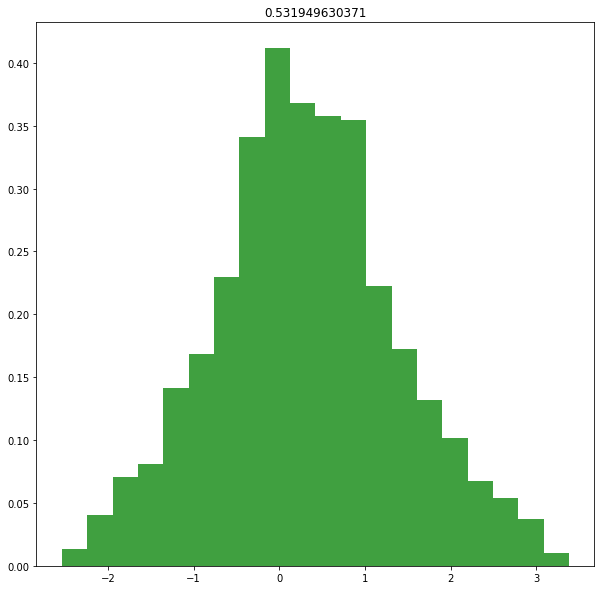

In [15]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(X_validate[:,1].reshape(-1,1), 20, density=True, facecolor='g', alpha=0.75)
x = np.linspace(-5,5,100)
plt.title((local_weighted_estimator(X_validate)))
plt.show()

### (normalized) Hermite polynomials

In [16]:
def generate_k_vec(d, K):
    r = list(range(K+1))
    k = []
    for roll in product(r, repeat = d):
        k.append(list(roll))
    k.remove([0,0])
    return k
def H(k, x):
    h = hermitenorm(k)(x) /  np.sqrt(math.factorial(k))
    return h
def Hermite_val(k_vec,x_vec):
    P = 1.0
    d = x_vec.shape[0]
    for i in range(d):
        P = P * H(k_vec[i],x_vec[i])
    return P

In [17]:
k_comb = generate_k_vec(d,2)
k_comb

[[0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]

### Reduced variant

## Fitting linear regression for 

## $Q_{p,l}(x) = \mathbb{E} \left[f(X_p) | X_l = x\right] = G_{p-l}(x) = \mathbb{E} \left[ f(\varPhi ^{p-l} (x, \xi))\right]$


### $\forall l: \quad G_r(x) = \mathbb{E} \left[f(X_{l+r}) | X_l = x \right] $

### Algorithm (trajectory + all variations):

## $\hat{G}_r = argmin_{\psi \in \Psi} \sum_{s = 1}^{N_{train}} \sum_{l = N + 1}^{N+n-r} \left| f(X_{l+r}^{(s)}) - \psi(X_l^{(s)})\right|^2$

### where $\quad  1 \leq r \leq n-1$

## $\hat{G}_0(x) = f(x)$

In [19]:
def pol_ar_1d(x): #x.shape = (2,1)
    return np.array([1,x[0],x[1],x[0]*x[1],x[0]**2,x[1]**2,x[0]**2 *x[1],x[0]* x[1]**2, x[0]**3, x[1]**3])

def generate_X_reduced(XX, r):
    N_train = XX.shape[0]
    N = XX.shape[1]
    X = np.empty((N_train * (N-r) ,10))
    all_points = XX[:, :N-r].reshape(-1,2)
    X[:,0] = np.ones(N_train * (N-r))
    X[:,1] = all_points[:,0].squeeze()
    X[:,2] =all_points[:,1].squeeze()
    X[:,3] = (all_points[:,0] * all_points[:,1]).squeeze()
    X[:,4] = (all_points[:,0]**2).squeeze()
    X[:,5] = (all_points[:,1]**2).squeeze()
    X[:,6] = (all_points[:,0]**2 * all_points[:,1]).squeeze()
    X[:,7] = (all_points[:,0] * all_points[:,1]**2).squeeze()
    X[:,8] = (all_points[:,0]**3).squeeze()
    X[:,9] = (all_points[:,1]**3).squeeze()
    return X 


def generate_y_reduced(XX,r):
    N_train = XX.shape[0]
    N = XX.shape[1]
    y = np.zeros(N_train * (N-r))
    y = XX[:, r:].sum(axis = 2).reshape(-1)
    return y

def G_pml_fit(XX):
    N_train = XX.shape[0]
    N = XX.shape[1]
    Betas = np.zeros((N,10))
    for r in tqdm(range(N)):
        X = generate_X_reduced(XX,r)
        y = generate_y_reduced(XX,r)
        beta = np.linalg.inv(X.T @ X) @ X.T @ y
        Betas[r] = beta
    return Betas

def G_pml_predict(x,pml,Betas):
    x_pol = pol_ar_1d(x)
    beta = Betas[pml]
    return (x_pol @ beta)

In [20]:
Betas_reduced = G_pml_fit(XX)

100%|██████████| 1000/1000 [04:05<00:00,  4.07it/s]


In [22]:
np.save('GM(2d)_Betas_reduced(train_1000).npy',Betas_reduced)

In [44]:
# fig = plt.figure(figsize=(12,6))
# ax = fig.gca(projection='3d')

# # Make data.
# X_plot = np.arange(-2, 2, 0.25)
# Y_plot = np.arange(-2, 2, 0.25)
# X_plot, Y_plot = np.meshgrid(X_plot, Y_plot)
# R_plot = X_plot**2 + Y_plot**2
# Z_plot_real = R_plot - np.cos(X_plot)-1

# Z_plot = np.empty((X_plot.shape[0],X_plot.shape[0]))
# for i in range(X_plot.shape[0]):
#     XY_plot = np.hstack((X_plot[i].reshape(-1,1,1), Y_plot[i].reshape(-1,1,1)))
#     for j in range(X_plot.shape[0]):
#         Z_plot[i,j] = q_pl_predict(XY_plot[j],55,55,Betas)

# # Plot the surfaces
# surf_1 = ax.plot_surface(X_plot, Y_plot, Z_plot, cmap = 'autumn',alpha = 0.55,
#                       linewidth=0, antialiased=False)

# surf_2 = ax.plot_surface(X_plot, Y_plot, Z_plot_real, cmap='Blues',alpha = 0.65,
#                       linewidth=0, antialiased=False)

# # Customize the z axis.
# ax.set_xlim(-2, 2)
# ax.set_ylim(-2, 2)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# # Add a color bar which maps values to colors.
# fig.colorbar(surf_1, shrink=0.5, aspect=5)
# fig.colorbar(surf_2, shrink=0.5, aspect=5)

# plt.show()

### Explicit formula for $\hat{a}_{p,l,k}(x)$:

#### $\hat{a}_{p,l,k} (x)= \mathbb{E} \left[ H_k(\xi) \hat{Q}_{p,l}(x - h\nabla U(x) + \sqrt{2h}\xi)\right] =\int_{-\infty}^{\infty} H_k(\xi) \hat{Q}_{p,l}(x - h\nabla U(x) + \sqrt{2h}\xi) \varphi (\xi) d \xi$

#### $\hat{Q}_{p,l} (y_1, y_2) = \sum_{i=0}^{i=m} \sum_{j=0}^{j=m} \beta_{i,j} y_1^i y_2^j$

#### $(\xi_1, \xi_2) \sim \mathcal{N} (0, I_2)$

#### $\hat{a}_{p,l,k} = \mathbb{E} \left[H_{k_1}(\xi_1)H_{k_2}(\xi_2) \left(\sum_{i=0}^{i=m} \sum_{j=0}^{j=m} \beta_{i,j} (\hat{x}_1 + \sqrt{2h}\xi_1)^i(\hat{x}_2 + \sqrt{2h}\xi_2)^j \right) \right]=\\=\sum_{i=0}^{i=m} \sum_{j=0}^{j=m} \beta_{i,j} \mathbb{E} \left[H_{k_1}(\xi_1)H_{k_2}(\xi_2)(\hat{x}_1 + \sqrt{2h}\xi_1)^i(\hat{x}_2 + \sqrt{2h}\xi_2)^j  \right] = \\ = \sum_{i=0}^{i=m} \sum_{j=0}^{j=m} \beta_{i,j} E^1_i E^2_j$

#### $ \text{with}\quad E_i^1 = \mathbb{E} \left[H_{k_1}(\xi_1) (\hat{x}_1 + \sqrt{2h}\xi_1)^i \right]\text{and}\quad E_j^2 = \mathbb{E} \left[H_{k_2}(\xi_2) (\hat{x}_2 + \sqrt{2h}\xi_2)^j \right]$ 

####  $\text{since }\quad \xi^j = j! \sum_{s = 0}^{s \leq j/2} \frac{1}{2^s} \frac{1}{s! \sqrt{(j-2s)!}}H_{j-2s}(\xi) \quad \text{we have}$:

#### $E_i^1 = \sum_{t=0}^{t=i} \sum_{s = 0}^{s \leq t/2} t! \frac{1}{2^s} \frac{1}{s! \sqrt{(t-2s)!}} C_i^t \hat{x}_1^{i-t} (\sqrt{2h})^t \int_{-\infty}^{\infty} H_{k_1}(\xi_1) H_{t - 2s}(\xi_1) \varphi(\xi_1) d \xi_1$

#### $E_j^2 = \sum_{t=0}^{t=j} \sum_{s = 0}^{s \leq t/2} t! \frac{1}{2^s} \frac{1}{s! \sqrt{(t-2s)!}} C_j^t\hat{x}_2^{j-t} (\sqrt{2h})^t \int_{-\infty}^{\infty} H_{k_2}(\xi_2) H_{t - 2s}(\xi_2) \varphi(\xi_2) d \xi_2 $

#### $\text{and}\quad \int_{-\infty}^{\infty} H_{k_r}(\xi_r) H_{w - 2s}(\xi_r) \varphi(\xi_r) d \xi_r =\begin{cases}1 &\text{if $ k_r = w-2s$}\\  0 &\text{else} \end{cases}$

In [24]:
degrees = np.array([[0,0],[1,0],[0,1],[1,1],[2,0],[0,2],[2,1],[1,2],[3,0],[0,3]])

In [25]:
def a_plk(X,p,l,k_vec):
    h = 0.1
    S = 0
    x_hat = X[l-1] - h*f_grad(X[l-1])
    for ind,(i,j) in enumerate(degrees):
        S_small_1 = 0
        S_small_2 = 0
        for t in range (i+1):
            for s in range (int(t/2 +1)):
                if (k_vec[0] == t - 2*s):
                    S_small_1 = S_small_1 + comb(N=i, k = t, exact = True) * x_hat[0]**(i-t) * \
                    math.factorial(t)*1/math.factorial(s)*1 / np.sqrt(math.factorial(t-2*s)) *np.sqrt(2*h)**t /2**s
                else:
                    pass
        for t in range (j+1):
            for s in range (int(t/2 +1)):
                if (k_vec[1] == t - 2*s):
                    S_small_2 = S_small_2 + comb(N=j, k = t, exact = True) * x_hat[1]**(j-t) * \
                    math.factorial(t)*1/math.factorial(s)*1 / np.sqrt(math.factorial(t-2*s)) *np.sqrt(2*h)**t /2**s
                else:
                    pass
        S = S + Betas_reduced[p-l,ind] * S_small_1 *S_small_2
    return S

In [27]:
def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

P = estimator(XX)
print ("variance of weighted estimator (1.4) on training sample:",P.var(ddof=1))

def M_bias(k_vec,X,Z,Betas_reduced,i):
    N = X.shape[0]
    S = 0
    for p in range(N):
        for l in range (p+1):
            if (p-l<100):
                s = a_plk(X,p,l,k_vec)* Hermite_val(k_vec,Z[l])
                S = S + s
    return S/N

def estimator_bias(k,XX,ZZ,Betas,first, last):
    M_results = Parallel(n_jobs=-1)(delayed(M_bias)(k,XX[i],ZZ[i],Betas_reduced,i)for i in range(first, last))
    return np.array(M_results).reshape(-1)

100%|██████████| 1000/1000 [00:00<00:00, 59443.93it/s]

variance of weighted estimator (1.4) on training sample: 0.0859296695775


### check formula ( full)

In [28]:
time_1 = timeit.default_timer()
print ("P =",local_weighted_estimator(X_validate))
for i in range(len(k_comb)):
    print ("M ({}) = {} [Time:{}]".format(k_comb[i],M_bias(k_comb[i],X_validate,Z_validate,Betas_reduced,0),
                                           timeit.default_timer()-time_1))

P = 0.531949630371
M ([0, 1]) = [ 0.35737499] [Time:65.29895158403087]
M ([0, 2]) = [ 0.00192954] [Time:127.27987457206473]
M ([1, 0]) = [ 0.19681928] [Time:192.82514930400066]
M ([1, 1]) = [-0.00019881] [Time:249.81057488708757]
M ([1, 2]) = [ 0.00022852] [Time:303.982279835036]
M ([2, 0]) = [ 0.00648458] [Time:365.6367956150789]
M ([2, 1]) = [ -6.80190628e-06] [Time:419.2161298880819]
M ([2, 2]) = [ 0.] [Time:467.04987234203145]


In [29]:
X = XX[7]
Z = ZZ[7]
time_1 = timeit.default_timer()
print ("P =",local_weighted_estimator(X))
for i in range(len(k_comb)):
    print ("M ({}) = {} [Time:{}]".format(k_comb[i],M_bias(k_comb[i],X,Z,Betas_reduced,0),timeit.default_timer()-time_1))

P = -0.228384985829
M ([0, 1]) = [-0.18357483] [Time:66.33952656493057]
M ([0, 2]) = [ 0.00048045] [Time:128.99296121799853]
M ([1, 0]) = [-0.02882034] [Time:194.35075932194013]
M ([1, 1]) = [ 0.00467724] [Time:251.82624557300005]
M ([1, 2]) = [-0.00034817] [Time:306.1870181869017]
M ([2, 0]) = [ 0.00294836] [Time:368.7162681230111]
M ([2, 1]) = [-0.00115788] [Time:422.9408121960005]
M ([2, 2]) = [ 0.] [Time:471.2528492229758]


## Check on test sample

In [30]:
np.random.seed(987)
X, Z = generate_lmc(a,d,100000)
XX_test, ZZ_test = generate_paths(X,200,a,d,1000)
P_test = estimator(XX_test)

100%|██████████| 200/200 [00:00<00:00, 49872.82it/s]


In [31]:
print ('Variance of Pi = ',P_test.var(dtype=np.float64,ddof = 1))

Variance of Pi =  0.0929643537005


In [ ]:
M_1 = estimator_bias(k_comb[0],XX_test,ZZ_test,Betas_reduced, 0, 200)
np.save('GM(2d)_M_results_test_1.npy',M_1)

M_2 = estimator_bias(k_comb[1],XX_test,ZZ_test,Betas_reduced, 0, 200)
np.save('GM(2d)_M_results_test_2.npy',M_2)

M_3 = estimator_bias(k_comb[2],XX_test,ZZ_test,Betas_reduced, 0, 200)
np.save('GM(2d)_M_results_test_3.npy',M_3)

M_4 = estimator_bias(k_comb[3],XX_test,ZZ_test,Betas_reduced, 0, 200) 
np.save('GM(2d)_M_results_test_4.npy',M_4)

M_5 = estimator_bias(k_comb[4],XX_test,ZZ_test,Betas_reduced, 0, 200)
np.save('GM(2d)_M_results_test_5.npy',M_5)

M_6 = estimator_bias(k_comb[5],XX_test,ZZ_test,Betas_reduced, 0, 200)
np.save('GM(2d)_M_results_test_6.npy',M_6)

M_7 = estimator_bias(k_comb[6],XX_test,ZZ_test,Betas_reduced, 0, 200)
np.save('GM(2d)_M_results_test_7.npy',M_7)

M_8 = estimator_bias(k_comb[7],XX_test,ZZ_test,Betas_reduced, 0, 200)
np.save('GM(2d)_M_results_test_8.npy',M_8)

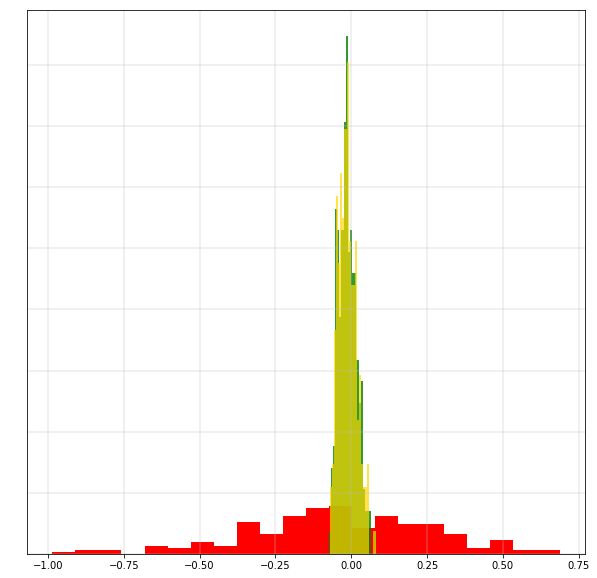

In [49]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(P_test.reshape(-1,1), 22, facecolor='r', density=True,
                            alpha=1, label=r"$\pi$")

n, bins, patches = plt.hist((P_test-M_1 - M_2 -M_3).reshape(-1,1),22, density=True, facecolor='g', 
                            alpha=0.8, label="Distribution of $\pi - M^1_N$")

n, bins, patches = plt.hist((P_test-M_1 - M_2 -M_3 -M_4-M_5 -M_6 -M_7).reshape(-1,1),22, density=True, facecolor='gold', 
                            alpha=0.7, label="Distribution of $\pi - M^1_N$")

#plt.legend(loc=2, prop={'size': 17})
plt.grid(which='major', axis='x', linewidth=0.45, linestyle='-', color='0.75')
plt.grid(which='major', axis='y', linewidth=0.45, linestyle='-', color='0.75')

plt.tick_params(
    axis='y',
    color = 'w',
    labelcolor = 'w',
    which='both')
# plt.xlim(-0.5, 0.5)
plt.show()

In [64]:
print ('Variance of Pi = ',P_test.var(dtype=np.float64,ddof = 1))
print ('-----------------------------------------------------')
print ('Variance of new estimator (K=1)= ',(P_test-M_1 - M_3 - M_4 ).var(dtype=np.float64,ddof = 1))
print ("=====================================================")
print ('Variance of new estimator (K=2)= ',(P_test-M_1 - M_2 - M_3 -M_4 - M_5 - M_6 -M_7 -M_8).var(dtype=np.float64,ddof = 1))
print ("=====================================================")

Variance of Pi =  0.0929643537005
-----------------------------------------------------
Variance of new estimator (K=1)=  0.000837575184641
Variance of new estimator (K=2)=  0.000852084051565


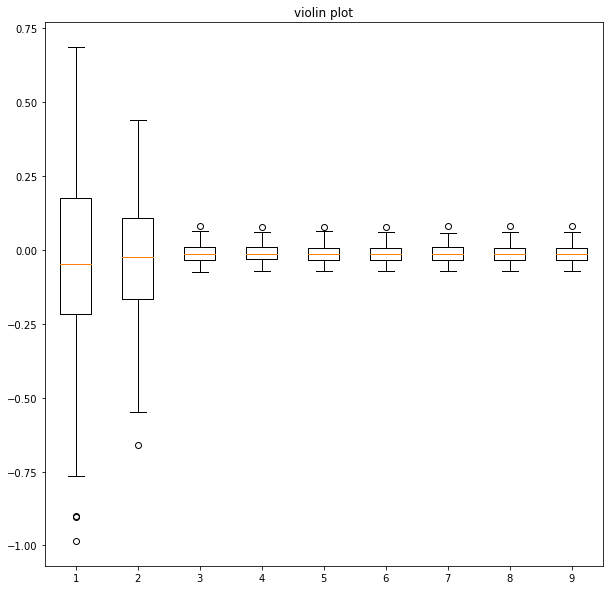

In [52]:
plt.figure(figsize=(10,10))

# generate some random test data
all_data = [P_test, P_test - M_1,P_test - M_1 -M_3,P_test - M_1 - M_3 - M_4 , 
           P_test - M_1 - M_2 -M_3 -M_4, P_test - M_1 - M_2 -M_3 -M_4 -M_5, P_test - M_1 - M_2 -M_3 -M_4 -M_5 -M_6,
           P_test - M_1 - M_2 -M_3 -M_4 -M_5 -M_6 -M_7, P_test - M_1 - M_2 -M_3 -M_4 -M_5 -M_6 - M_7 - M_8]

# plot violin plot
plt.boxplot(all_data)
plt.title('violin plot')

plt.show()

In [50]:
k_comb

[[0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]

In [70]:
print ('Variance of Pi = ',P_test.var(dtype=np.float64,ddof = 1))
print ('-----------------------------------------------------')
print ('Variance of new estimator  = {} --->([0,1])'.format((P_test-M_1 ).var(dtype=np.float64,ddof = 1),7))
print ("=====================================================")
print ('Variance of new estimator  = {} --->([0,1],[1,0])'.format((P_test-M_1 - M_3 ).var(dtype=np.float64,ddof = 1),7))
print ("=====================================================")
print ('Variance of new estimator  = {}  --->([0,1],[1,0],[1,1])'.format((P_test-M_1 - M_3 - M_4 ).var(dtype=np.float64,ddof = 1)))
print ("=====================================================")
print ('Variance of new estimator  = {}  --->([0,1],[1,0],[1,1],[0,2])'.format((P_test-M_1 - M_3 - M_4 -M_2).var(dtype=np.float64,ddof = 1)))
print ("=====================================================")
print ('Variance of new estimator  = {}  --->([0,1],[1,0],[1,1],[0,2],[1,2])'.format((P_test-M_1 - M_3 - M_4 - M_2 - M_5 ).var(dtype=np.float64,ddof = 1)))
print ("=====================================================")
print ('Variance of new estimator  = {}  --->([0,1],[1,0],[1,1],[0,2],[1,2], [2,0])'.format((P_test-M_1 - M_3 - M_4 - M_2 - M_5 -M_6).var(dtype=np.float64,ddof = 1)))
print ("=====================================================")
print ('Variance of new estimator  = {}  --->([0,1],[1,0],[1,1],[0,2],[1,2], [2,0],[2,1])'.format((P_test-M_1 - M_3 - M_4 - M_2 - M_5 -M_6 -M_7).var(dtype=np.float64,ddof = 1)))
print ("=====================================================")
print ('Variance of new estimator  = {}  --->([0,1],[1,0],[1,1],[0,2],[1,2], [2,0],[2,1],[2,2])'.format((P_test-M_1 - M_3 - M_4 - M_2 - M_5 -M_6 -M_7 -M_8).var(dtype=np.float64,ddof = 1)))
print ("=====================================================")

Variance of Pi =  0.0929643537005
-----------------------------------------------------
Variance of new estimator  = 0.04510942751975246 --->([0,1])
Variance of new estimator  = 0.000861511374833784 --->([0,1],[1,0])
Variance of new estimator  = 0.0008375751846405142  --->([0,1],[1,0],[1,1])
Variance of new estimator  = 0.0008445080526673995  --->([0,1],[1,0],[1,1],[0,2])
Variance of new estimator  = 0.0008458429530006567  --->([0,1],[1,0],[1,1],[0,2],[1,2])
Variance of new estimator  = 0.0008523930149229786  --->([0,1],[1,0],[1,1],[0,2],[1,2], [2,0])
Variance of new estimator  = 0.00085208405156503  --->([0,1],[1,0],[1,1],[0,2],[1,2], [2,0],[2,1])
Variance of new estimator  = 0.00085208405156503  --->([0,1],[1,0],[1,1],[0,2],[1,2], [2,0],[2,1],[2,2])
